## Hyperparameter Tuning

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.


Reference: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [1]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from timm.models.swin_transformer import SwinTransformer


import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# determine the project root - required to import DataHandler from utils folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

modelName = "SwinAccuracy"

# configuring log file
log_dir = os.path.join(project_root, "logs")
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, F"{modelName}_training_log.txt") #NOTE: specify based on model training

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

MODEL_SAVE_DIR = os.path.join(project_root, "models", modelName)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) 

LOSS_RESULTS_SAVE_DIR = os.path.join(project_root, "results", F"{modelName}_loss")
os.makedirs(LOSS_RESULTS_SAVE_DIR, exist_ok=True) 

ACC_RESULTS_SAVE_DIR = os.path.join(project_root, "results", F"{modelName}_acc")
os.makedirs(ACC_RESULTS_SAVE_DIR, exist_ok=True) 

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-19 22:10:40,548	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-19 22:10:40,679	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

device = get_device()

Using device: CUDA (GPU)


## Data Download
This is adapted from SeparatingData.ipynb
Download the processed dataset from Google Drive if yet to.

In [3]:
# DATA_DIR = "../input/final_split_training_augmented"
# ZIP_URL = "https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr"
# ZIP_FILENAME = "../input/final_split.zip"
# ROOT_DIR = "../input"

# download_dataset(DATA_DIR, ZIP_URL, ZIP_FILENAME, ROOT_DIR)

## Subset Data Load
For faster hyperparameter tuning, use a subset of the dataset to find the most optimised set of hyperparameters.
Loads dataset from processed dataset which should have been split to train, test, eval.

In [3]:
SPLIT_DATASET = os.path.abspath("../../input/final_split_15Apr2025")
BATCH_SIZE = 64

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    weights.transforms()
])

TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69


## Full Data Load
When doing the entire training for the entire dataset (full dataset not used in hyperparameter tuning)

In [4]:
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572


## Model Specifications
This is where you should replace with your model.

EfficientNetB5 Partial Transfer Learning:
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 

In [5]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionalSelectiveFusion(nn.Module):
    """Simple channel‑attention fusion block"""
    def __init__(self, in_channels: int):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg(x))
        return x * w



class SwinFicientNet(nn.Module):
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None):
        super().__init__()

        # 1) EfficientNet-B5 feature extractor only
        eff = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
        self.backbone = eff.features  # <-- 4D conv maps
        feat_channels = 2048          # EfficientNetB5's final feature‐map channels

        # Freeze all EfficientNet layers, then optionally unfreeze some
        for p in self.backbone.parameters():
            p.requires_grad = False
        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for p in self.backbone[idx].parameters():
                    p.requires_grad = True

        # 2) Squeeze‐Excitation on the conv maps
        self.se = SqueezeExcitationBlock(feat_channels)
        self.asf   = AttentionalSelectiveFusion(2048)

        # 3) Project into 96 channels for Swin
        self.project    = nn.Conv2d(feat_channels, 96, kernel_size=1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((14, 14))

        # 4) Swin Transformer head (classifier baked in)
        self.swin = SwinTransformer(
            img_size=14,
            patch_size=1,
            in_chans=96,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.1,
            ape=False,
            patch_norm=True,
            num_classes=num_classes
        )

        # 5) Optional extra MLP (if you want more hidden layers after Swin)
        layers = []
        if hidden_sizes:
            inp = num_classes
            for h in hidden_sizes:
                layers += [
                    nn.Dropout(dropout),
                    nn.Linear(inp, h),
                    self._get_activation(activation)
                ]
                inp = h
            layers += [nn.Dropout(dropout), nn.Linear(inp, num_classes)]
            self.post_swin = nn.Sequential(*layers)
        else:
            self.post_swin = nn.Identity()
    def _get_activation(self, act: str) -> nn.Module:
        act = act.lower()
        return {
            'relu'     : nn.ReLU(),
            'tanh'     : nn.Tanh(),
            'sigmoid'  : nn.Sigmoid(),
            'leakyrelu': nn.LeakyReLU()
        }[act]

    def forward(self, x):
        x = self.backbone(x)    # [B, 2048, H, W]
        x = self.se(x)          # SE block
        x = self.asf(x)         # attentional fusion
        x = self.project(x)     # [B,  96, H, W]
        x = self.adapt_pool(x)  # [B,  96, 14,14]
        x = self.swin(x)        # [B, num_classes]
        return self.post_swin(x)


In [6]:
print(f"Using device: {device}")
model = SwinFicientNet(num_classes=4, dropout=0.3, hidden_sizes=[256, 128], activation='relu', unfreeze_blocks=[7]).to(device)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: SwinFicientNet
SwinFicientNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activat

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

References:
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune

CHECKPOINT_DIR = os.path.abspath(F"../../models/hyptune/{modelName}")
def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = SwinFicientNet(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu"),
        unfreeze_blocks = config.get("unfreeze_blocks", [7])
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()  #UPDATE: add this line for accuracy
            running_total   += targets.size(0)  #UPDATE: add this line for accuracy
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        epoch_acc  = running_correct / running_total
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        print(f"[TRAIN] epoch {epoch+1}: loss={epoch_loss:.4f} acc={epoch_acc:.3f}")  #UPDATE: edit this line for accuracy

        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0) #UPDATE: edit this variable name
            val_correct += (outputs.argmax(1) == targets).sum().item() #UPDATE: add this line for accuracy
            val_total   += targets.size(0) #UPDATE: add this line for accuracy
    
    avg_val_loss = val_loss / val_total
    avg_val_acc  = val_correct / val_total
    print(f"[VAL] loss={avg_val_loss:.4f} acc={avg_val_acc:.3f}") #UPDATE: edit this line for accuracy
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss, "acc": avg_val_acc}) #UPDATE: edit this line for accuracy

In [8]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=10,     # min iterations before stopping
    reduction_factor=3,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format
'''
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "dropout": tune.uniform(0.1, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh"]),
    "freeze_backbone": tune.choice([True, False]),
    "num_epochs": 2, 
    "optimiser": tune.choice([optim.Adam, optim.SGD]),
    "criterion": tune.choice([nn.CrossEntropyLoss, nn.NLLLoss]),
    "unfreeze_blocks": tune.choice([[7], [6, 7], [5, 6, 7]]),
}
'''

# this is what i specified for the example because i am running on cpu
# config = {
#     "lr": tune.loguniform(1e-5, 1e-2),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "dropout": tune.uniform(0.1, 0.5),
#     "freeze_backbone": tune.choice([True]),
#     "num_epochs": 2,
# }


# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-5, 5e-5),    
    "weight_decay": tune.loguniform(1e-5, 2e-5),
    "dropout": tune.uniform(0.39, 0.41),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu"]), #Removed gelu
    "unfreeze_blocks": tune.choice([[6, 7]]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 12, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials    
    tune_config=tune.TuneConfig( 
        scheduler=asha_scheduler, 
        search_alg=optuna_search, 
        num_samples=15,  # number of trials to run 
        trial_dirname_creator=trial_dirname_creator, 
        trial_name_creator=trial_name_creator,  
    ),

    run_config=tune.RunConfig(
        name=modelName,
        storage_path=F"C:/ray_results/{modelName}", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="acc", mode="max", filter_nan_and_inf=False).config) #UPDATE: edit this line to use accuracy

(train_model pid=23048) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=23048) Epoch 1/10, Training Loss: 1.3966
(train_model pid=23048) [TRAIN] epoch 1: loss=1.3966 acc=0.250


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=23048) Epoch 2/10, Training Loss: 1.3979
(train_model pid=23048) [TRAIN] epoch 2: loss=1.3979 acc=0.245


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=23048) Epoch 3/10, Training Loss: 1.3939
(train_model pid=23048) [TRAIN] epoch 3: loss=1.3939 acc=0.246


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=23048) Epoch 4/10, Training Loss: 1.3960
(train_model pid=23048) [TRAIN] epoch 4: loss=1.3960 acc=0.249


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=23048) Epoch 5/10, Training Loss: 1.3936
(train_model pid=23048) [TRAIN] epoch 5: loss=1.3936 acc=0.255


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=23048) Epoch 6/10, Training Loss: 1.3921
(train_model pid=23048) [TRAIN] epoch 6: loss=1.3921 acc=0.250


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=23048) Epoch 7/10, Training Loss: 1.3952
(train_model pid=23048) [TRAIN] epoch 7: loss=1.3952 acc=0.253


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=23048) Epoch 8/10, Training Loss: 1.3923
(train_model pid=23048) [TRAIN] epoch 8: loss=1.3923 acc=0.250


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=23048) Epoch 9/10, Training Loss: 1.3908
(train_model pid=23048) [TRAIN] epoch 9: loss=1.3908 acc=0.261


Epoch 10/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=23048) Epoch 10/10, Training Loss: 1.3943
(train_model pid=23048) [TRAIN] epoch 10: loss=1.3943 acc=0.247


2025-04-19 22:22:07,326	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=23048) [VAL] loss=1.3842 acc=0.280
(train_model pid=12256) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=12256) Epoch 1/10, Training Loss: 1.4069
(train_model pid=12256) [TRAIN] epoch 1: loss=1.4069 acc=0.254


Epoch 2/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=12256) Epoch 2/10, Training Loss: 1.3787
(train_model pid=12256) [TRAIN] epoch 2: loss=1.3787 acc=0.291


Epoch 3/10: 100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


(train_model pid=12256) Epoch 3/10, Training Loss: 1.3709
(train_model pid=12256) [TRAIN] epoch 3: loss=1.3709 acc=0.306


Epoch 4/10: 100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


(train_model pid=12256) Epoch 4/10, Training Loss: 1.3584
(train_model pid=12256) [TRAIN] epoch 4: loss=1.3584 acc=0.321


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=12256) Epoch 5/10, Training Loss: 1.3379
(train_model pid=12256) [TRAIN] epoch 5: loss=1.3379 acc=0.373


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=12256) Epoch 6/10, Training Loss: 1.3190
(train_model pid=12256) [TRAIN] epoch 6: loss=1.3190 acc=0.399


Epoch 7/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=12256) Epoch 7/10, Training Loss: 1.2959
(train_model pid=12256) [TRAIN] epoch 7: loss=1.2959 acc=0.413


Epoch 8/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=12256) Epoch 8/10, Training Loss: 1.2668
(train_model pid=12256) [TRAIN] epoch 8: loss=1.2668 acc=0.445


Epoch 9/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=12256) Epoch 9/10, Training Loss: 1.2393
(train_model pid=12256) [TRAIN] epoch 9: loss=1.2393 acc=0.453


Epoch 10/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=12256) Epoch 10/10, Training Loss: 1.2073
(train_model pid=12256) [TRAIN] epoch 10: loss=1.2073 acc=0.473


2025-04-19 22:33:23,193	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=12256) [VAL] loss=1.1788 acc=0.498
(train_model pid=21368) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=21368) Epoch 1/10, Training Loss: 1.3934
(train_model pid=21368) [TRAIN] epoch 1: loss=1.3934 acc=0.250


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21368) Epoch 2/10, Training Loss: 1.3660
(train_model pid=21368) [TRAIN] epoch 2: loss=1.3660 acc=0.300


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21368) Epoch 3/10, Training Loss: 1.2742
(train_model pid=21368) [TRAIN] epoch 3: loss=1.2742 acc=0.372


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21368) Epoch 4/10, Training Loss: 1.0826
(train_model pid=21368) [TRAIN] epoch 4: loss=1.0826 acc=0.492


Epoch 5/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=21368) Epoch 5/10, Training Loss: 0.8645
(train_model pid=21368) [TRAIN] epoch 5: loss=0.8645 acc=0.626


Epoch 6/10:  98%|█████████▊| 62/63 [01:07<00:01,  1.08s/it]


(train_model pid=21368) Epoch 6/10, Training Loss: 0.7272
(train_model pid=21368) [TRAIN] epoch 6: loss=0.7272 acc=0.681


Epoch 7/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=21368) Epoch 7/10, Training Loss: 0.6309
(train_model pid=21368) [TRAIN] epoch 7: loss=0.6309 acc=0.732


Epoch 8/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=21368) Epoch 8/10, Training Loss: 0.5627
(train_model pid=21368) [TRAIN] epoch 8: loss=0.5627 acc=0.747


Epoch 9/10: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


(train_model pid=21368) Epoch 9/10, Training Loss: 0.5124
(train_model pid=21368) [TRAIN] epoch 9: loss=0.5124 acc=0.771


Epoch 10/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=21368) Epoch 10/10, Training Loss: 0.4620
(train_model pid=21368) [TRAIN] epoch 10: loss=0.4620 acc=0.783


2025-04-19 22:44:46,249	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=21368) [VAL] loss=0.5906 acc=0.803
(train_model pid=26296) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=26296) Epoch 1/10, Training Loss: 1.3964
(train_model pid=26296) [TRAIN] epoch 1: loss=1.3964 acc=0.254


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=26296) Epoch 2/10, Training Loss: 1.3824
(train_model pid=26296) [TRAIN] epoch 2: loss=1.3824 acc=0.287


Epoch 3/10: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


(train_model pid=26296) Epoch 3/10, Training Loss: 1.3805
(train_model pid=26296) [TRAIN] epoch 3: loss=1.3805 acc=0.282


Epoch 4/10: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


(train_model pid=26296) Epoch 4/10, Training Loss: 1.3720
(train_model pid=26296) [TRAIN] epoch 4: loss=1.3720 acc=0.298


Epoch 5/10: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


(train_model pid=26296) Epoch 5/10, Training Loss: 1.3649
(train_model pid=26296) [TRAIN] epoch 5: loss=1.3649 acc=0.308


Epoch 6/10: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


(train_model pid=26296) Epoch 6/10, Training Loss: 1.3640
(train_model pid=26296) [TRAIN] epoch 6: loss=1.3640 acc=0.316


Epoch 7/10: 100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


(train_model pid=26296) Epoch 7/10, Training Loss: 1.3482
(train_model pid=26296) [TRAIN] epoch 7: loss=1.3482 acc=0.340


Epoch 8/10: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it]


(train_model pid=26296) Epoch 8/10, Training Loss: 1.3441
(train_model pid=26296) [TRAIN] epoch 8: loss=1.3441 acc=0.355


Epoch 9/10: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


(train_model pid=26296) Epoch 9/10, Training Loss: 1.3305
(train_model pid=26296) [TRAIN] epoch 9: loss=1.3305 acc=0.383


Epoch 10/10: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


(train_model pid=26296) Epoch 10/10, Training Loss: 1.3295
(train_model pid=26296) [TRAIN] epoch 10: loss=1.3295 acc=0.373


2025-04-19 22:56:31,563	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=26296) [VAL] loss=1.3008 acc=0.398
(train_model pid=7064) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it]


(train_model pid=7064) Epoch 1/10, Training Loss: 1.4016
(train_model pid=7064) [TRAIN] epoch 1: loss=1.4016 acc=0.246


Epoch 2/10: 100%|██████████| 63/63 [01:10<00:00,  1.11s/it]


(train_model pid=7064) Epoch 2/10, Training Loss: 1.3961
(train_model pid=7064) [TRAIN] epoch 2: loss=1.3961 acc=0.260


Epoch 3/10: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


(train_model pid=7064) Epoch 3/10, Training Loss: 1.3907
(train_model pid=7064) [TRAIN] epoch 3: loss=1.3907 acc=0.261


Epoch 4/10: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


(train_model pid=7064) Epoch 4/10, Training Loss: 1.3891
(train_model pid=7064) [TRAIN] epoch 4: loss=1.3891 acc=0.266


Epoch 5/10: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


(train_model pid=7064) Epoch 5/10, Training Loss: 1.3895
(train_model pid=7064) [TRAIN] epoch 5: loss=1.3895 acc=0.251


Epoch 6/10: 100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


(train_model pid=7064) Epoch 6/10, Training Loss: 1.3884
(train_model pid=7064) [TRAIN] epoch 6: loss=1.3884 acc=0.260


Epoch 7/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=7064) Epoch 7/10, Training Loss: 1.3921
(train_model pid=7064) [TRAIN] epoch 7: loss=1.3921 acc=0.261


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=7064) Epoch 8/10, Training Loss: 1.3898
(train_model pid=7064) [TRAIN] epoch 8: loss=1.3898 acc=0.266


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=7064) Epoch 9/10, Training Loss: 1.3897
(train_model pid=7064) [TRAIN] epoch 9: loss=1.3897 acc=0.251


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=7064) Epoch 10/10, Training Loss: 1.3899
(train_model pid=7064) [TRAIN] epoch 10: loss=1.3899 acc=0.255


2025-04-19 23:08:12,258	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=7064) [VAL] loss=1.3817 acc=0.294
(train_model pid=21604) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=21604) Epoch 1/10, Training Loss: 1.2863
(train_model pid=21604) [TRAIN] epoch 1: loss=1.2863 acc=0.391


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 2/10, Training Loss: 0.8561
(train_model pid=21604) [TRAIN] epoch 2: loss=0.8561 acc=0.643


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 3/10, Training Loss: 0.6302
(train_model pid=21604) [TRAIN] epoch 3: loss=0.6302 acc=0.751


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 4/10, Training Loss: 0.4475
(train_model pid=21604) [TRAIN] epoch 4: loss=0.4475 acc=0.829


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 5/10, Training Loss: 0.3173
(train_model pid=21604) [TRAIN] epoch 5: loss=0.3173 acc=0.882


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 6/10, Training Loss: 0.2402
(train_model pid=21604) [TRAIN] epoch 6: loss=0.2402 acc=0.910


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 7/10, Training Loss: 0.2105
(train_model pid=21604) [TRAIN] epoch 7: loss=0.2105 acc=0.924


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 8/10, Training Loss: 0.1727
(train_model pid=21604) [TRAIN] epoch 8: loss=0.1727 acc=0.940


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 9/10, Training Loss: 0.1428
(train_model pid=21604) [TRAIN] epoch 9: loss=0.1428 acc=0.949


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=21604) Epoch 10/10, Training Loss: 0.1156
(train_model pid=21604) [TRAIN] epoch 10: loss=0.1156 acc=0.957


2025-04-19 23:19:25,645	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=21604) [VAL] loss=0.6542 acc=0.817
(train_model pid=22488) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


(train_model pid=22488) Epoch 1/10, Training Loss: 1.4149
(train_model pid=22488) [TRAIN] epoch 1: loss=1.4149 acc=0.250


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22488) Epoch 2/10, Training Loss: 1.4002
(train_model pid=22488) [TRAIN] epoch 2: loss=1.4002 acc=0.271


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22488) Epoch 3/10, Training Loss: 1.3731
(train_model pid=22488) [TRAIN] epoch 3: loss=1.3731 acc=0.308


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22488) Epoch 4/10, Training Loss: 1.3480
(train_model pid=22488) [TRAIN] epoch 4: loss=1.3480 acc=0.334


Epoch 5/10:  98%|█████████▊| 62/63 [01:05<00:01,  1.06s/it]


(train_model pid=22488) Epoch 5/10, Training Loss: 1.2968
(train_model pid=22488) [TRAIN] epoch 5: loss=1.2968 acc=0.396


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22488) Epoch 6/10, Training Loss: 1.2622
(train_model pid=22488) [TRAIN] epoch 6: loss=1.2622 acc=0.423


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22488) Epoch 7/10, Training Loss: 1.2222
(train_model pid=22488) [TRAIN] epoch 7: loss=1.2222 acc=0.458


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22488) Epoch 8/10, Training Loss: 1.1867
(train_model pid=22488) [TRAIN] epoch 8: loss=1.1867 acc=0.493


Epoch 9/10:  98%|█████████▊| 62/63 [01:05<00:01,  1.06s/it]


(train_model pid=22488) Epoch 9/10, Training Loss: 1.1548
(train_model pid=22488) [TRAIN] epoch 9: loss=1.1548 acc=0.502


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22488) Epoch 10/10, Training Loss: 1.1136
(train_model pid=22488) [TRAIN] epoch 10: loss=1.1136 acc=0.527


2025-04-19 23:30:40,398	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=22488) [VAL] loss=0.9988 acc=0.616
(train_model pid=13432) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=13432) Epoch 1/10, Training Loss: 1.4745
(train_model pid=13432) [TRAIN] epoch 1: loss=1.4745 acc=0.247


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=13432) Epoch 2/10, Training Loss: 1.4255
(train_model pid=13432) [TRAIN] epoch 2: loss=1.4255 acc=0.241


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=13432) Epoch 3/10, Training Loss: 1.4121
(train_model pid=13432) [TRAIN] epoch 3: loss=1.4121 acc=0.243


Epoch 4/10:  98%|█████████▊| 62/63 [01:05<00:01,  1.06s/it]


(train_model pid=13432) Epoch 4/10, Training Loss: 1.3965
(train_model pid=13432) [TRAIN] epoch 4: loss=1.3965 acc=0.257


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=13432) Epoch 5/10, Training Loss: 1.3554
(train_model pid=13432) [TRAIN] epoch 5: loss=1.3554 acc=0.317


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=13432) Epoch 6/10, Training Loss: 1.3046
(train_model pid=13432) [TRAIN] epoch 6: loss=1.3046 acc=0.367


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=13432) Epoch 7/10, Training Loss: 1.2693
(train_model pid=13432) [TRAIN] epoch 7: loss=1.2693 acc=0.394


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=13432) Epoch 8/10, Training Loss: 1.2302
(train_model pid=13432) [TRAIN] epoch 8: loss=1.2302 acc=0.419


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=13432) Epoch 9/10, Training Loss: 1.1936
(train_model pid=13432) [TRAIN] epoch 9: loss=1.1936 acc=0.444


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=13432) Epoch 10/10, Training Loss: 1.1692
(train_model pid=13432) [TRAIN] epoch 10: loss=1.1692 acc=0.439


2025-04-19 23:41:55,813	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=13432) [VAL] loss=1.1709 acc=0.453
(train_model pid=15652) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 1/10, Training Loss: 1.4118
(train_model pid=15652) [TRAIN] epoch 1: loss=1.4118 acc=0.249


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=15652) Epoch 2/10, Training Loss: 1.3906
(train_model pid=15652) [TRAIN] epoch 2: loss=1.3906 acc=0.278


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 3/10, Training Loss: 1.3873
(train_model pid=15652) [TRAIN] epoch 3: loss=1.3873 acc=0.286


Epoch 4/10: 100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


(train_model pid=15652) Epoch 4/10, Training Loss: 1.3764
(train_model pid=15652) [TRAIN] epoch 4: loss=1.3764 acc=0.295


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 5/10, Training Loss: 1.3735
(train_model pid=15652) [TRAIN] epoch 5: loss=1.3735 acc=0.308


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 6/10, Training Loss: 1.3610
(train_model pid=15652) [TRAIN] epoch 6: loss=1.3610 acc=0.333


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 7/10, Training Loss: 1.3559
(train_model pid=15652) [TRAIN] epoch 7: loss=1.3559 acc=0.346


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 8/10, Training Loss: 1.3527
(train_model pid=15652) [TRAIN] epoch 8: loss=1.3527 acc=0.342


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 9/10, Training Loss: 1.3407
(train_model pid=15652) [TRAIN] epoch 9: loss=1.3407 acc=0.369


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=15652) Epoch 10/10, Training Loss: 1.3299
(train_model pid=15652) [TRAIN] epoch 10: loss=1.3299 acc=0.384


2025-04-19 23:53:08,435	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=15652) [VAL] loss=1.3186 acc=0.401
(train_model pid=25268) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=25268) Epoch 1/10, Training Loss: 1.4093
(train_model pid=25268) [TRAIN] epoch 1: loss=1.4093 acc=0.251


Epoch 2/10:  98%|█████████▊| 62/63 [01:05<00:01,  1.05s/it]


(train_model pid=25268) Epoch 2/10, Training Loss: 1.3427
(train_model pid=25268) [TRAIN] epoch 2: loss=1.3427 acc=0.325


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25268) Epoch 3/10, Training Loss: 1.2466
(train_model pid=25268) [TRAIN] epoch 3: loss=1.2466 acc=0.400


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25268) Epoch 4/10, Training Loss: 1.1441
(train_model pid=25268) [TRAIN] epoch 4: loss=1.1441 acc=0.445


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25268) Epoch 5/10, Training Loss: 1.0357
(train_model pid=25268) [TRAIN] epoch 5: loss=1.0357 acc=0.496


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25268) Epoch 6/10, Training Loss: 0.9530
(train_model pid=25268) [TRAIN] epoch 6: loss=0.9530 acc=0.549


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25268) Epoch 7/10, Training Loss: 0.8732
(train_model pid=25268) [TRAIN] epoch 7: loss=0.8732 acc=0.596


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25268) Epoch 8/10, Training Loss: 0.8265
(train_model pid=25268) [TRAIN] epoch 8: loss=0.8265 acc=0.619


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25268) Epoch 9/10, Training Loss: 0.7588
(train_model pid=25268) [TRAIN] epoch 9: loss=0.7588 acc=0.662


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=25268) Epoch 10/10, Training Loss: 0.7097
(train_model pid=25268) [TRAIN] epoch 10: loss=0.7097 acc=0.689


2025-04-20 00:04:23,088	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=25268) [VAL] loss=0.7057 acc=0.751
(train_model pid=25052) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=25052) Epoch 1/10, Training Loss: 1.3404
(train_model pid=25052) [TRAIN] epoch 1: loss=1.3404 acc=0.370


Epoch 2/10: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


(train_model pid=25052) Epoch 2/10, Training Loss: 0.7260
(train_model pid=25052) [TRAIN] epoch 2: loss=0.7260 acc=0.713


Epoch 3/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=25052) Epoch 3/10, Training Loss: 0.3818
(train_model pid=25052) [TRAIN] epoch 3: loss=0.3818 acc=0.855


Epoch 4/10: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


(train_model pid=25052) Epoch 4/10, Training Loss: 0.2369
(train_model pid=25052) [TRAIN] epoch 4: loss=0.2369 acc=0.914


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=25052) Epoch 5/10, Training Loss: 0.2002
(train_model pid=25052) [TRAIN] epoch 5: loss=0.2002 acc=0.927


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25052) Epoch 6/10, Training Loss: 0.1241
(train_model pid=25052) [TRAIN] epoch 6: loss=0.1241 acc=0.957


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25052) Epoch 7/10, Training Loss: 0.0905
(train_model pid=25052) [TRAIN] epoch 7: loss=0.0905 acc=0.967


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25052) Epoch 8/10, Training Loss: 0.0632
(train_model pid=25052) [TRAIN] epoch 8: loss=0.0632 acc=0.979


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25052) Epoch 9/10, Training Loss: 0.0616
(train_model pid=25052) [TRAIN] epoch 9: loss=0.0616 acc=0.979


Epoch 10/10:  98%|█████████▊| 62/63 [01:05<00:01,  1.07s/it]


(train_model pid=25052) Epoch 10/10, Training Loss: 0.0598
(train_model pid=25052) [TRAIN] epoch 10: loss=0.0598 acc=0.980


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]
2025-04-20 00:15:40,850	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=25052) [VAL] loss=0.6106 acc=0.834
(train_model pid=22052) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=22052) Epoch 1/10, Training Loss: 1.4032
(train_model pid=22052) [TRAIN] epoch 1: loss=1.4032 acc=0.244


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22052) Epoch 2/10, Training Loss: 1.3902
(train_model pid=22052) [TRAIN] epoch 2: loss=1.3902 acc=0.246


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=22052) Epoch 3/10, Training Loss: 1.2935
(train_model pid=22052) [TRAIN] epoch 3: loss=1.2935 acc=0.360


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=22052) Epoch 4/10, Training Loss: 1.0999
(train_model pid=22052) [TRAIN] epoch 4: loss=1.0999 acc=0.461


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=22052) Epoch 5/10, Training Loss: 0.9604
(train_model pid=22052) [TRAIN] epoch 5: loss=0.9604 acc=0.519


Epoch 6/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=22052) Epoch 6/10, Training Loss: 0.8690
(train_model pid=22052) [TRAIN] epoch 6: loss=0.8690 acc=0.560


Epoch 7/10: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


(train_model pid=22052) Epoch 7/10, Training Loss: 0.8441
(train_model pid=22052) [TRAIN] epoch 7: loss=0.8441 acc=0.583


Epoch 8/10: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


(train_model pid=22052) Epoch 8/10, Training Loss: 0.7427
(train_model pid=22052) [TRAIN] epoch 8: loss=0.7427 acc=0.601


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=22052) Epoch 9/10, Training Loss: 0.7232
(train_model pid=22052) [TRAIN] epoch 9: loss=0.7232 acc=0.622


Epoch 10/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=22052) Epoch 10/10, Training Loss: 0.6857
(train_model pid=22052) [TRAIN] epoch 10: loss=0.6857 acc=0.643


2025-04-20 00:26:59,764	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=22052) [VAL] loss=0.7035 acc=0.657
(train_model pid=24296) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]


(train_model pid=24296) Epoch 1/10, Training Loss: 1.4005
(train_model pid=24296) [TRAIN] epoch 1: loss=1.4005 acc=0.250


Epoch 2/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=24296) Epoch 2/10, Training Loss: 1.3337
(train_model pid=24296) [TRAIN] epoch 2: loss=1.3337 acc=0.325


Epoch 3/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=24296) Epoch 3/10, Training Loss: 1.1995
(train_model pid=24296) [TRAIN] epoch 3: loss=1.1995 acc=0.407


Epoch 4/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=24296) Epoch 4/10, Training Loss: 1.0717
(train_model pid=24296) [TRAIN] epoch 4: loss=1.0717 acc=0.471


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=24296) Epoch 5/10, Training Loss: 0.9575
(train_model pid=24296) [TRAIN] epoch 5: loss=0.9575 acc=0.516


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=24296) Epoch 6/10, Training Loss: 0.8607
(train_model pid=24296) [TRAIN] epoch 6: loss=0.8607 acc=0.571


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=24296) Epoch 7/10, Training Loss: 0.7645
(train_model pid=24296) [TRAIN] epoch 7: loss=0.7645 acc=0.641


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=24296) Epoch 8/10, Training Loss: 0.6641
(train_model pid=24296) [TRAIN] epoch 8: loss=0.6641 acc=0.716


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=24296) Epoch 9/10, Training Loss: 0.6390
(train_model pid=24296) [TRAIN] epoch 9: loss=0.6390 acc=0.743


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=24296) Epoch 10/10, Training Loss: 0.4858
(train_model pid=24296) [TRAIN] epoch 10: loss=0.4858 acc=0.796


2025-04-20 00:38:18,430	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=24296) [VAL] loss=0.8996 acc=0.796
(train_model pid=25852) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=25852) Epoch 1/10, Training Loss: 1.3505
(train_model pid=25852) [TRAIN] epoch 1: loss=1.3505 acc=0.386


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 2/10, Training Loss: 0.6860
(train_model pid=25852) [TRAIN] epoch 2: loss=0.6860 acc=0.727


Epoch 3/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 3/10, Training Loss: 0.3978
(train_model pid=25852) [TRAIN] epoch 3: loss=0.3978 acc=0.853


Epoch 4/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 4/10, Training Loss: 0.2583
(train_model pid=25852) [TRAIN] epoch 4: loss=0.2583 acc=0.906


Epoch 5/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 5/10, Training Loss: 0.1640
(train_model pid=25852) [TRAIN] epoch 5: loss=0.1640 acc=0.944


Epoch 6/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 6/10, Training Loss: 0.1431
(train_model pid=25852) [TRAIN] epoch 6: loss=0.1431 acc=0.949


Epoch 7/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 7/10, Training Loss: 0.0940
(train_model pid=25852) [TRAIN] epoch 7: loss=0.0940 acc=0.968


Epoch 8/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 8/10, Training Loss: 0.0991
(train_model pid=25852) [TRAIN] epoch 8: loss=0.0991 acc=0.967


Epoch 9/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 9/10, Training Loss: 0.0530
(train_model pid=25852) [TRAIN] epoch 9: loss=0.0530 acc=0.982


Epoch 10/10: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


(train_model pid=25852) Epoch 10/10, Training Loss: 0.0570
(train_model pid=25852) [TRAIN] epoch 10: loss=0.0570 acc=0.980


2025-04-20 00:49:32,573	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=25852) [VAL] loss=0.5294 acc=0.858
(train_model pid=26232) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=26232) Epoch 1/10, Training Loss: 1.2882
(train_model pid=26232) [TRAIN] epoch 1: loss=1.2882 acc=0.400


Epoch 2/10: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


(train_model pid=26232) Epoch 2/10, Training Loss: 0.7461
(train_model pid=26232) [TRAIN] epoch 2: loss=0.7461 acc=0.701


Epoch 3/10: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


(train_model pid=26232) Epoch 3/10, Training Loss: 0.4646
(train_model pid=26232) [TRAIN] epoch 3: loss=0.4646 acc=0.825


Epoch 4/10: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]


(train_model pid=26232) Epoch 4/10, Training Loss: 0.3128
(train_model pid=26232) [TRAIN] epoch 4: loss=0.3128 acc=0.887


Epoch 5/10: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]


(train_model pid=26232) Epoch 5/10, Training Loss: 0.2460
(train_model pid=26232) [TRAIN] epoch 5: loss=0.2460 acc=0.910


Epoch 6/10: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]


(train_model pid=26232) Epoch 6/10, Training Loss: 0.1654
(train_model pid=26232) [TRAIN] epoch 6: loss=0.1654 acc=0.940


Epoch 7/10: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]


(train_model pid=26232) Epoch 7/10, Training Loss: 0.1211
(train_model pid=26232) [TRAIN] epoch 7: loss=0.1211 acc=0.955


Epoch 8/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=26232) Epoch 8/10, Training Loss: 0.0994
(train_model pid=26232) [TRAIN] epoch 8: loss=0.0994 acc=0.965


Epoch 9/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=26232) Epoch 9/10, Training Loss: 0.1112
(train_model pid=26232) [TRAIN] epoch 9: loss=0.1112 acc=0.960


Epoch 10/10: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


(train_model pid=26232) Epoch 10/10, Training Loss: 0.0865
(train_model pid=26232) [TRAIN] epoch 10: loss=0.0865 acc=0.969


2025-04-20 01:00:59,729	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-20 01:00:59,752	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/SwinAccuracy/SwinAccuracy' in 0.0220s.
2025-04-20 01:00:59,765	INFO tune.py:1041 -- Total run time: 10208.09 seconds (10208.01 seconds for the tuning loop).


(train_model pid=26232) [VAL] loss=0.6066 acc=0.817
Best config: {'lr': 4.601387815472845e-05, 'weight_decay': 1.5630330063758725e-05, 'dropout': 0.3979133339185768, 'hidden_sizes': None, 'activation': 'relu', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001CC73509090>, 'criterion': <function <lambda> at 0x000001CC73508D30>}


In [11]:
loss_best_config = results.get_best_result(metric="loss", mode="min").config
print("Loss best config:", loss_best_config)

Loss best config: {'lr': 4.601387815472845e-05, 'weight_decay': 1.5630330063758725e-05, 'dropout': 0.3979133339185768, 'hidden_sizes': None, 'activation': 'relu', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001CC73509090>, 'criterion': <function <lambda> at 0x000001CC73508D30>}


In [9]:
best_config = results.get_best_result(metric="acc", mode="max").config #UPDATE: edit this line to use accuracy
print("Accuracy best config:", best_config)

Accuracy best config: {'lr': 4.803167159624574e-05, 'weight_decay': 1.5561398870236366e-05, 'dropout': 0.3990350742240228, 'hidden_sizes': None, 'activation': 'leakyrelu', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x0000021E8629A0E0>, 'criterion': <function <lambda> at 0x0000021E86299AB0>}


In [ ]:
#### Good configs
# best_config = {
#     'lr': 3.49354e-05,
#     'weight_decay': 1.59637e-05,
#     'dropout': 0.3986,
#     'hidden_sizes': [256, 128],
#     'activation': 'leakyrelu',
#     'unfreeze_blocks': [6, 7],
#     'num_epochs': 10,
#     'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
#     'criterion': lambda: nn.CrossEntropyLoss()
# }

In [12]:
final_model = SwinFicientNet(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
final_model = final_model.to(device)
logging.info("Model instantiated on device: %s", device)

In [14]:
optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

In [20]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
best_val_accuracy = 0.0
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct / total
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
    # if epoch_val_loss < best_val_loss:
    #     best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, F"{modelName}_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch 1/50 - Train Loss: 0.3488, Val Loss: 0.5909


Epoch 2/50: 100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch 2/50 - Train Loss: 0.3183, Val Loss: 0.5744


Epoch 3/50: 100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch 3/50 - Train Loss: 0.3091, Val Loss: 0.5494


Epoch 4/50: 100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch 4/50 - Train Loss: 0.2857, Val Loss: 0.6211


Epoch 5/50: 100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch 5/50 - Train Loss: 0.2768, Val Loss: 0.6716


Epoch 6/50: 100%|██████████| 126/126 [02:28<00:00,  1.18s/it]


Epoch 6/50 - Train Loss: 0.2795, Val Loss: 0.6144


Epoch 7/50: 100%|██████████| 126/126 [02:26<00:00,  1.16s/it]


Epoch 7/50 - Train Loss: 0.2541, Val Loss: 0.7324
Early stopping triggered.


In [21]:
# load best model from training
final_model.load_state_dict(torch.load(best_model_path))
final_model.eval()

print(len(FULL_TEST_LOADER.dataset))

# Evaluate on the test set
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in FULL_TEST_LOADER:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

572
Test Loss: 0.5920, Test Accuracy: 86.36%


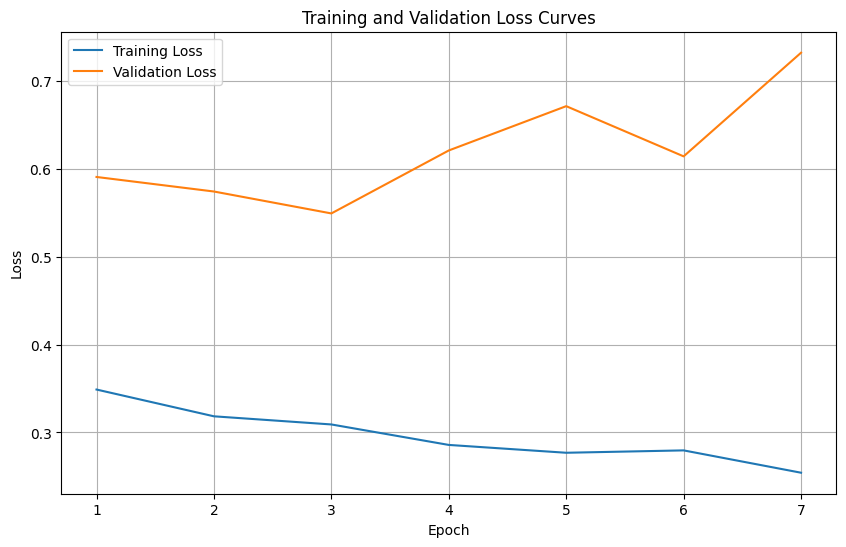

In [22]:
# plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves.png")
plt.show()

Test Loss: 0.5920, Test Accuracy: 86.19%


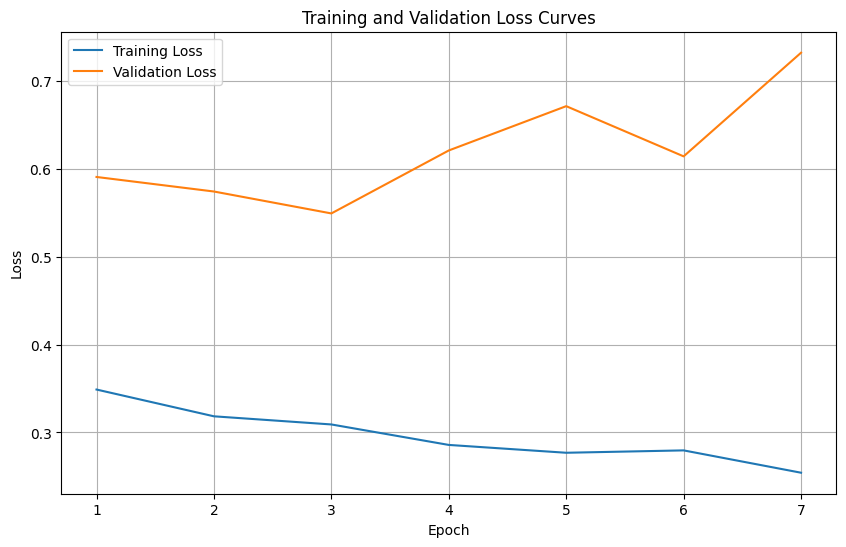


Classification Report:
               precision    recall  f1-score   support

       angry       0.89      0.84      0.86       140
       happy       0.90      0.95      0.92       148
     relaxed       0.80      0.84      0.82       146
         sad       0.86      0.81      0.84       138

    accuracy                           0.86       572
   macro avg       0.86      0.86      0.86       572
weighted avg       0.86      0.86      0.86       572



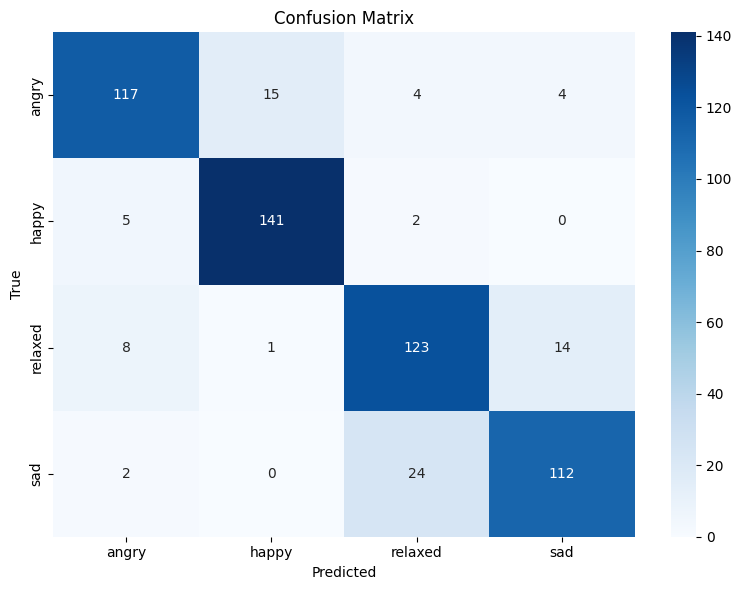

In [23]:
# load best model from training 
final_model.load_state_dict(torch.load(best_model_path)) 
final_model.to(device) 
final_model.eval() 
 
# initialise metrics 
correct = 0 
total = 0 
test_loss = 0.0 
all_preds = [] 
all_labels = [] 
 
with torch.no_grad(): 
    for images, labels in FULL_TEST_LOADER: 
        images, labels = images.to(device), labels.to(device) 
        outputs = final_model(images) 
        # for test loss 
        loss = criterion(outputs, labels) 
        test_loss += loss.item() * images.size(0) 
        # for accuracy 
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 
 
        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu 
        all_labels.extend(labels.cpu().numpy()) 
 
test_loss = test_loss / len(FULL_TEST_LOADER.dataset) 
test_accuracy = correct / total 
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%") 
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100) 
 
# plotting training and validation loss curves 
if 'train_losses' in globals() and 'val_losses' in globals(): 
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss") 
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss") 
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training and Validation Loss Curves") 
    plt.legend() 
    plt.grid(True) 
    loss_curve_path = os.path.join("..", "results", modelName, "loss_curves.png") #NOTE: specify by model name 
    plt.savefig(loss_curve_path) 
    plt.show() 
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path) 
else: 
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.") 
 
# generate and log classification report 
class_names = FULL_TEST_LOADER.dataset.classes 
report = classification_report(all_labels, all_preds, target_names=class_names) 
print("\nClassification Report:\n", report) 
logging.info("Classification Report:\n%s", report) 
 
# generate confusion matrix 
cm = confusion_matrix(all_labels, all_preds) 
 
# save confusion matrix as image 
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax) 
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.title("Confusion Matrix") 
plt.tight_layout() 
 
conf_matrix_path = os.path.join("..", "results", modelName, "confusion_matrix.png") #NOTE: specify by model name 
fig.savefig(conf_matrix_path) 
plt.show(fig) 
 
logging.info("Confusion matrix saved to: %s", conf_matrix_path)
